In [510]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance
from mvlearn.embed import GCCA
import imp
imp.reload(utils)
from netrep.utils import align

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [511]:
sessions_1 = glob.glob('../Dataset_1/*')
sessions_2 = glob.glob('../Dataset_2/*')
sessions_3 = glob.glob('../Dataset_3/*')

sessions = sessions_1 + sessions_2 #+ sessions_3

In [512]:

HD_fold = []
n_folds = 10
n_pcs = 20
pca = PCA(n_components=n_pcs)


all_neurons = []
for session in tqdm.tqdm(sessions):

    # tuning curves computed with two halves of the behavioral data (same neurons)
    hd_data = loadmat(session + '/Analysis/HdTuning_xval_moveEp.mat')

    data_1 = hd_data["hAll1"][:,:,12]# last index is smoothing window. 12 seems great
    data_2 = hd_data["hAll2"][:,:,12]

    all_neurons.append([data_1,data_2])
    N = len(data_1[0])
    if N < 40:
        continue
    idx = np.arange(N)
    many_folds = []
    for fold in range(n_folds):

        np.random.shuffle(idx)
        pcs_1 = pca.fit_transform(data_1[:,idx[:N//2]])   
        pcs_2 = pca.fit_transform(data_2[:,idx[N//2:]])
        
        many_folds.append([pcs_1,pcs_2])

    HD_fold.append(many_folds)

    # cv in time


sh = np.shape(HD_fold)
HD_many_folds = np.array(HD_fold).transpose(1,0,2,3,4).reshape(sh[1],-1,sh[3],sh[4])
HD_fold  = HD_many_folds[0]


100%|██████████| 31/31 [00:19<00:00,  1.60it/s]


In [513]:
S=len(sessions)
print(S)

S_tot = len(HD_fold)
print(S_tot)

31
62


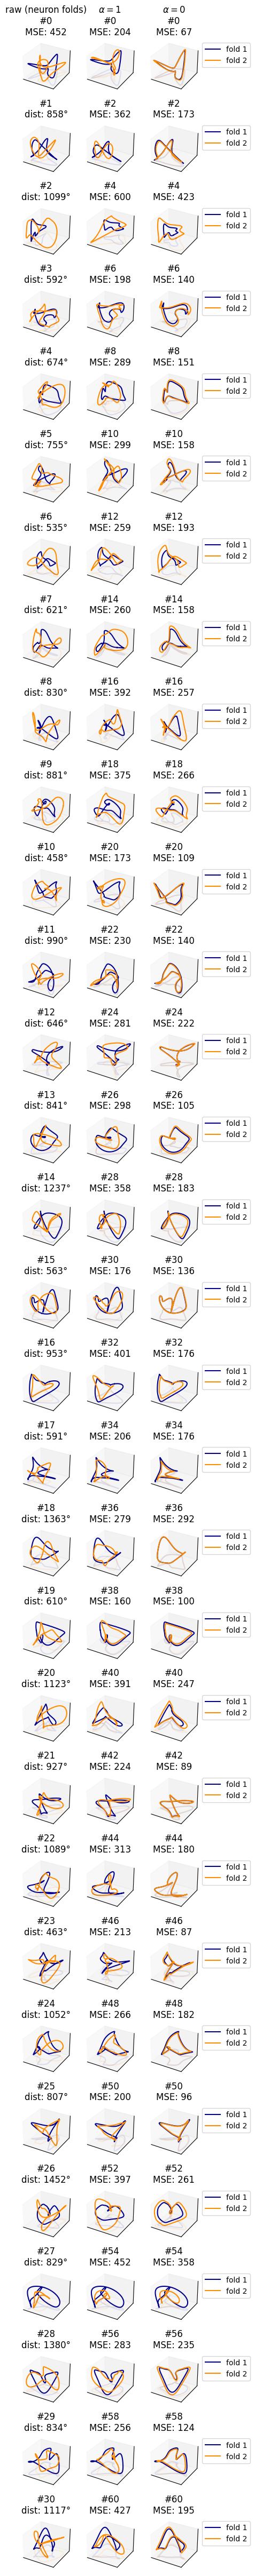

In [514]:

def plot_fold(Xi, Xj,ax):
    
    ax.plot(Xi[:,0], Xi[:,1], Xi[:,2],color="darkblue",label="fold 1")
    ax.plot(Xj[:,0], Xj[:,1], Xj[:,2],color="darkorange",label="fold 2")

    ax.plot(Xi[:,0], Xi[:,1], ax.get_zlim()[0],alpha=0.1,color="darkblue")
    ax.plot(Xj[:,0], Xj[:,1], ax.get_zlim()[0],alpha=0.1,color="darkorange")


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

fig = plt.figure(figsize=(9,S*2))

HD_fold  = HD_many_folds[0]

for s,si in enumerate(range(0,S_tot,S_tot//S)):

    Xi,Xj =  HD_fold[si],HD_fold[si+1]
    
    Xi_0, Xi_1 = whiten(Xi,alpha=0)[0],whiten(Xi,alpha=1)[0]
    Xj_0 = whiten(Xj,alpha=0)[0] @ align(whiten(Xj,alpha=0)[0],whiten(Xi,alpha=0)[0])
    Xj_1 = whiten(Xj,alpha=1)[0] @ align(whiten(Xj,alpha=1)[0],whiten(Xi,alpha=1)[0])
    

    # neural folds
    ax = fig.add_subplot(S,6,1 + (s*6), projection='3d')
    plot_fold(Xi,Xj,ax)
    if s == 0:
        #ax.set_title("raw (neuron folds)\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi,Xj))))
        ax.set_title("raw (neuron folds)\n#%i\nMSE: %i" % (si,np.linalg.norm(Xi-Xj)))
    else:
#        ax.set_title("#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi,Xj))))
        ax.set_title("#%i\ndist: %i°" % (s,np.linalg.norm(Xi-Xj)))

    ax = fig.add_subplot(S,6,2 + (s*6), projection='3d')
    plot_fold(Xi_1,Xj_1,ax)
    
    if s == 0:
        #ax.set_title(r"$\alpha=1$""\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_1,Xj_1))))
        ax.set_title(r"$\alpha=1$""\n#%i\nMSE: %i" % (si,np.linalg.norm(Xi_1-Xj_1)))
        
    else:
        #ax.set_title("\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_1,Xj_1))))
        ax.set_title("\n#%i\nMSE: %i" % (si,np.linalg.norm(Xi_1-Xj_1)))


    ax = fig.add_subplot(S,6,3 + (s*6), projection='3d')
    plot_fold(Xi_0,Xj_0,ax)
    
    if s == 0:
        #ax.set_title(r"$\alpha=0$""\n#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_0,Xj_0))))
        ax.set_title(r"$\alpha=0$""\n#%i\nMSE: %i" % (si,np.linalg.norm(Xi_0-Xj_0)))
        
    else:
        #ax.set_title("#%i\ndist: %i°" % (s,np.degrees(angular_distance(Xi_0-Xj_0))))
        ax.set_title("#%i\nMSE: %i" % (si,np.linalg.norm(Xi_0-Xj_0)))



    ax.legend(loc='upper right',bbox_to_anchor=(2, 1))


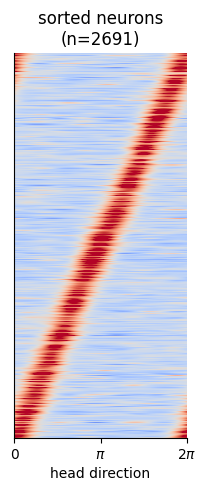

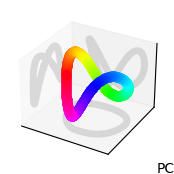

In [515]:


# 3D plot
# 360 colors
colors = sns.color_palette("hsv", 360)
fig = plt.figure(figsize=(5,5))
fold_1 = np.concatenate([(a[0] - np.mean(a[0],axis=0)).T for a in all_neurons])
fold_2 = np.concatenate([(a[1] - np.mean(a[1],axis=0)).T for a in all_neurons])



sorted_idx = [np.argmax(fold) for f,fold in enumerate(fold_1)]
sorted_fold = fold_2[np.argsort(sorted_idx)]

plt.imshow(sorted_fold,aspect=0.3,cmap='coolwarm',vmin=-10,vmax=10)
plt.title("sorted neurons\n(n=%i)" % len(sorted_fold))
plt.xlabel("head direction")
plt.xticks([0,180,360],[0,r'$\pi$',r'$2\pi$'])
# cbar = plt.colorbar(shrink=0.3,orientation='horizontal')
# cbar.set_label("neural activity\n(hz)")
# cbar.set_ticks([-10,0,10])
# cbar.set_ticklabels([-10,'mean',10])
sns.despine()
plt.ylim(10,len(sorted_fold)) # start at 10 to hide nan
plt.yticks([])
plt.savefig("../results/all_neurons.svg",bbox_inches='tight')    

idx = ~np.isnan(fold_1.mean(1))
pca_fit = PCA().fit(fold_1[idx].T)
pca_all = pca_fit.transform(fold_1[idx].T)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='3d')
[ax.plot(pca_all[p,0], pca_all[p,1], pca_all[p,2],'o',color=colors[p]) for p in range(360)]

z=ax.get_zlim()[0]*1.5
ax.plot(pca_all[:,0],pca_all[:,1],z*np.ones_like(pca_all[:,0]),color='gray',lw=5,alpha=0.25)

y=ax.get_ylim()[-1]*1.5
ax.plot(pca_all[:,0],y,pca_all[:,2],color='gray',lw=5,alpha=0.25)

x=ax.get_xlim()[0]*1.5
ax.plot(x,pca_all[:,1],pca_all[:,2],color='gray',lw=5,alpha=0.25)

[ax.plot(pca_all[p,0], pca_all[p,1], pca_all[p,2],'o',color=colors[p]) for p in range(360)]
ax.axis('equal')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
# ax.set_xlim(-65,65)
# ax.set_ylim(-65,65)
# ax.set_zlim(-65,65)

plt.savefig("../results/full_data_PCA.pdf",bbox_inches='tight')    

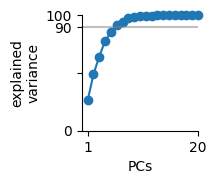

In [516]:
plt.figure(figsize=(1.5,1.5))
ax = fig.add_subplot(111)

plt.plot(range(1,21),np.cumsum(pca_fit.explained_variance_ratio_)[:20]*100,'o-',clip_on=False)
plt.xlim(0,20)
plt.ylim(0,100)
sns.despine()
#plt.gca().set_yscale('log')
xlabels = ['']*20
xlabels[0] = '1'
xlabels[19] = '20'
plt.xticks([1,20])
plt.ylabel("explained\nvariance")
plt.xlabel("PCs")
plt.yticks([0,50,90,100],['0','','90','100'])
plt.plot([0,20],[90,90],'-',color='gray',alpha=0.5)

plt.savefig("../results/full_data_PCA_variance.svg",bbox_inches='tight')

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


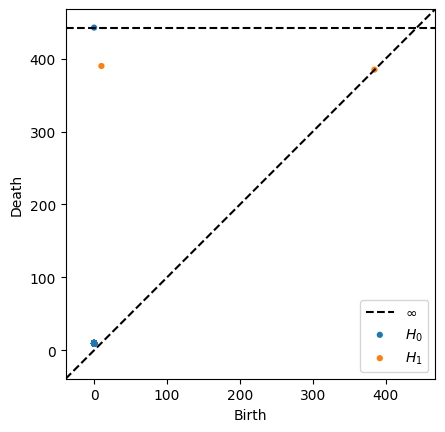

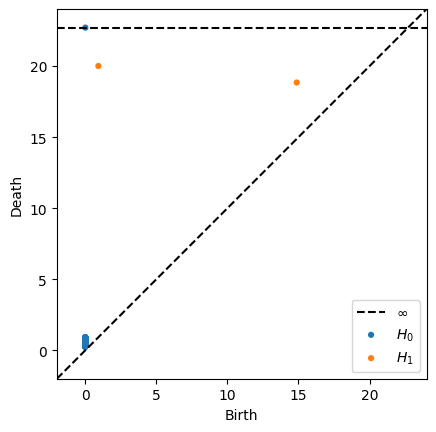

In [517]:
import numpy as np
from ripser import Rips

rips = Rips()
diagrams = rips.fit_transform(pca_all)
rips.plot(diagrams)

plt.figure()
diagrams = rips.fit_transform(HD_fold[0]) 

rips.plot(diagrams)


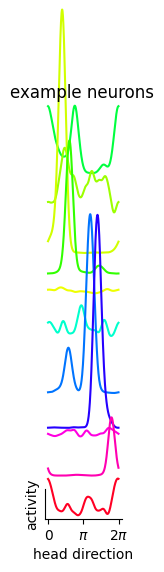

In [518]:
neurons_to_plot = sorted_fold[np.arange(0,len(sorted_fold),len(sorted_fold)//10)]


plt.figure(figsize=(1,5))
for ni,neuron in enumerate(neurons_to_plot):
    plt.subplot(len(neurons_to_plot),1,ni+1)
    plt.plot(neuron,clip_on=False,color=colors[np.argmax(neuron)])
    plt.xlabel("head direction")
    plt.xticks([0,180,360],[0,r'$\pi$',r'$2\pi$'])
    plt.ylabel("activity")
    sns.despine()
    plt.ylim(-2,2)
    plt.axis('off')

plt.axis('on')
plt.suptitle('example neurons')
plt.yticks([])

plt.savefig("../results/full_data_neurons.svg",bbox_inches='tight')


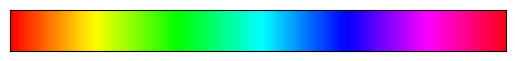

In [519]:
plt.imshow([list(range(0,360))]*30,cmap='hsv')
plt.xticks([])
plt.yticks([])
plt.savefig("../results/angles_color.pdf",bbox_inches='tight')


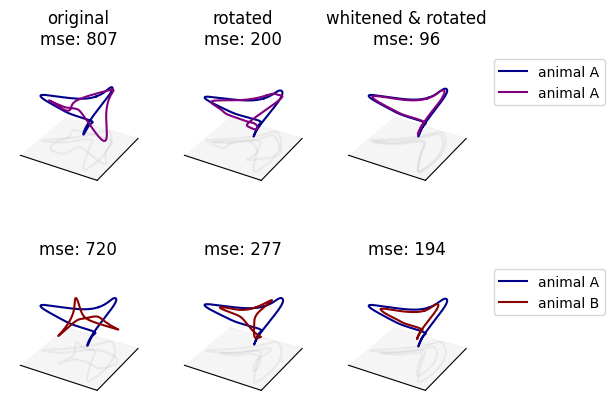

In [520]:

def plot_fold(Xi, Xj,ax,colors=None,labels=None):

    if colors is None:
        colors = ["darkblue","purple"]
    if labels is None:
        labels = ["fold 1","fold 2"]
    
    ax.plot(Xi[:,0], Xi[:,1], Xi[:,2],color=colors[0],label=labels[0])
    ax.plot(Xj[:,0], Xj[:,1], Xj[:,2],color=colors[1],label=labels[1])

    ax.plot(Xi[:,0], Xi[:,1], ax.get_zlim()[0]*2,alpha=0.1,color="gray")
    ax.plot(Xj[:,0], Xj[:,1], ax.get_zlim()[0],alpha=0.1,color="gray")

    # ax.plot(Xi[:,0], ax.get_ylim()[-1],Xi[:,2],alpha=0.1,color="gray")
    # ax.plot(Xj[:,0], ax.get_ylim()[-1],alpha=0.1,color="gray")

    # ax.plot(ax.get_xlim()[0], Xi[:,1],Xi[:,2],alpha=0.1,color="gray")
    # ax.plot(ax.get_xlim()[0], Xj[:,1],Xj[:,2],alpha=0.1,color="gray")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.zaxis.set_label_position('none')
    ax.zaxis.set_ticks_position('none')

fig = plt.figure(figsize=(6,5))
si = 50
HD_fold  = HD_many_folds[0]
Xi,Xj =  HD_fold[si],HD_fold[si+1]
Xi_0, Xi_1 = whiten(Xi,alpha=0)[0],whiten(Xi,alpha=1)[0]
Xj_0 = whiten(Xj,alpha=0)[0] @ align(whiten(Xj,alpha=0)[0],whiten(Xi,alpha=0)[0])
Xj_1 = whiten(Xj,alpha=1)[0] @ align(whiten(Xj,alpha=1)[0],whiten(Xi,alpha=1)[0])


### same animal different folds
labels = ['animal A','animal A']
ax = fig.add_subplot(231, projection='3d')
plot_fold(Xi,Xj,ax,labels=labels)
ax.set_title("original\nmse: %i" % (np.linalg.norm(Xi-Xj)))

ax = fig.add_subplot(232, projection='3d')
plot_fold(Xi_1,Xj_1,ax,labels=labels)
ax.set_title("rotated\nmse: %i" % (np.linalg.norm(Xi_1-Xj_1)))


ax = fig.add_subplot(233, projection='3d')
plot_fold(Xi_0,Xj_0,ax,labels=labels)
ax.set_title("whitened & rotated\nmse: %i" % (np.linalg.norm(Xi_0-Xj_0)))

ax.legend(loc='upper right',bbox_to_anchor=(2, 1))

### different animals
colors = ["darkblue","darkred"]
labels = ['animal A','animal B']
si_2 = 39
Xj = HD_fold[si_2]
Xi_0, Xi_1 = whiten(Xi,alpha=0)[0],whiten(Xi,alpha=1)[0]
Xj_0 = whiten(Xj,alpha=0)[0] @ align(whiten(Xj,alpha=0)[0],whiten(Xi,alpha=0)[0])
Xj_1 = whiten(Xj,alpha=1)[0] @ align(whiten(Xj,alpha=1)[0],whiten(Xi,alpha=1)[0])

ax = fig.add_subplot(234, projection='3d')
plot_fold(Xi,Xj,ax,colors,labels=labels)
ax.set_title("mse: %i" % (np.linalg.norm(Xi-Xj)))

ax = fig.add_subplot(235, projection='3d')
plot_fold(Xi_1,Xj_1,ax,colors,labels=labels)
ax.set_title("mse: %i" % (np.linalg.norm(Xi_1-Xj_1)))


ax = fig.add_subplot(236, projection='3d')
plot_fold(Xi_0,Xj_0,ax,colors,labels=labels)
ax.set_title("mse: %i" % (np.linalg.norm(Xi_0-Xj_0)))

ax.legend(loc='upper right',bbox_to_anchor=(2, 1))
plt.savefig("../results/animal_alignment_cross_validation.svg",bbox_inches='tight')
